In [22]:
from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2

path_to_images = Path().resolve().joinpath("BSDS300-test")
image_paths = glob(f"{str(path_to_images)}/*.jpg")

im = Image.open(image_paths[16])

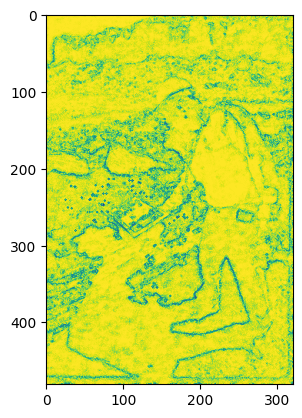

In [23]:
import numpy as np
from seasalt.seasalt import (
    plot_denoise,
    anisotropic_diffusion,
    get_c,
    apply_salt_pepper,
    fixed_window_outlier_filter,
)

# _, _, _, x = plot_denoise(im, sp_ratio=0.4, size=9)
im_gs = im.convert("L")
arr = np.array(im_gs)
seasoned_arr = apply_salt_pepper(arr, ratio=0.4)
corrected_image = fixed_window_outlier_filter(seasoned_arr, 9)
c, d_xx, d_yy = get_c(corrected_image)
plt.imshow(c)

In [24]:
isinstance(im_gs,np.ndarray)

False

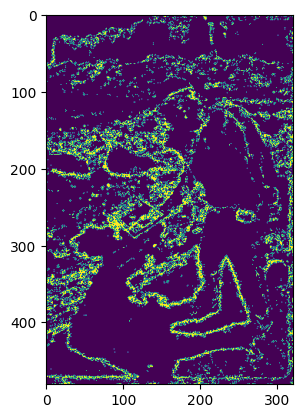

In [25]:
corrected_image = fixed_window_outlier_filter(seasoned_arr, 11)

c, d_xx, d_yy = get_c(corrected_image)
c[c > 0.8] = 0
c[c != 0] = 1
plt.imshow(c)

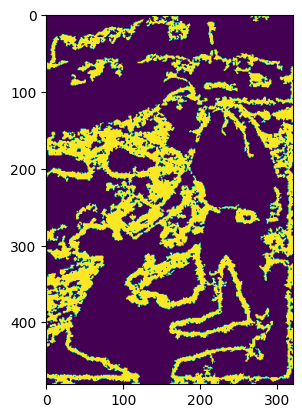

In [26]:
def get_edges(image):
    c, d_xx, d_yy = get_c(image)
    c = cv2.GaussianBlur(c, (3, 3), 0)
    c[c > 0.9] = 0
    c[c != 0] = 1
    plt.imshow(c)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        c.astype(np.uint8), connectivity=8
    )
    edges_mask = np.zeros_like(c, dtype=np.uint8)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= 100:
            edges_mask[labels == label] = 255
    return edges_mask

filtered_mask= get_edges(corrected_image)
plt.imshow(filtered_mask)

In [27]:
def skeletonize_custom(image_in):
    size = np.size(image_in)
    skel = np.zeros(image_in.shape, np.uint8)

    ret, image_edit = cv2.threshold(image_in, 0, 255, cv2.THRESH_BINARY )
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while cv2.countNonZero(image_edit) > 0:
        image_edit = cv2.morphologyEx(image_edit, cv2.MORPH_CLOSE, element)
        eroded = cv2.erode(image_edit, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(image_edit, temp)
        skel = cv2.bitwise_or(skel, temp)
        image_edit=eroded.copy()
    return cv2.GaussianBlur(skel.astype(np.uint8), (3, 3), 0)

In [28]:
def prune_edges(s):
    count = 0
    i = 0
    while count != np.sum(s):
        # non-zero pixel count
        count = np.sum(s)
        # examine 3x3 neighborhood of each pixel
        filt = cv2.boxFilter(s, -1, (3, 3), normalize=False)
        # if the center pixel of 3x3 neighborhood is zero, we are not interested in it
        s = s * filt
        # now we have pixels where the center pixel of 3x3 neighborhood is non-zero
        # if a pixels' 8-connectivity is less than 2 we can remove it
        # threshold is 3 here because the boxfilter also counted the center pixel
        s[s < 3] = 0
        # set max pixel value to 1
        s[s > 0] = 1
        i = i + 1
    return s

In [29]:
def plot_edges_against_base(edges, base):
    plt.imshow(np.where(edges == 0, base, 0), cmap="gray", vmin=0, vmax=255)

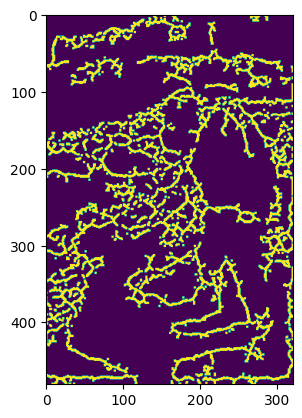

In [30]:
x = skeletonize_custom(filtered_mask)
x[x > 0] = 1
# kernel = np.ones((3, 3))
# do a morphologic close
# res = cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
plt.imshow(x)

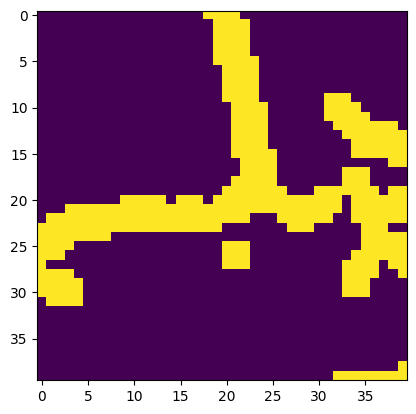

In [31]:
x = skeletonize_custom(filtered_mask)
x[x > 0] = 1
kernel = np.ones((3, 3))

plt.imshow(x[380:420,240:280])

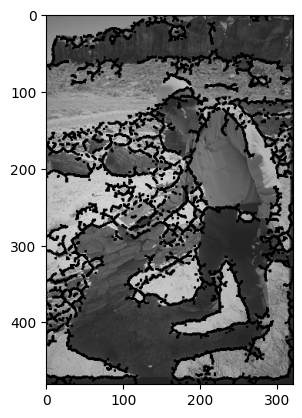

In [32]:
plot_edges_against_base(x, arr)

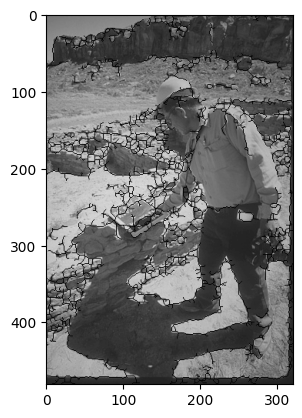

In [33]:
from skimage.morphology import skeletonize
skel = skeletonize(filtered_mask.astype(np.uint8))
plot_edges_against_base(skel, arr)

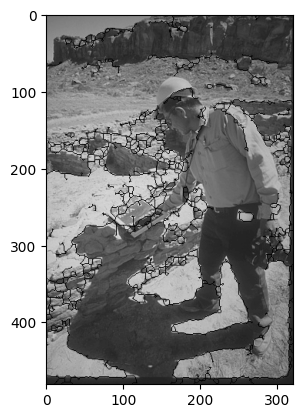

In [34]:
plot_edges_against_base(prune_edges(skel.astype(np.uint8)), arr)

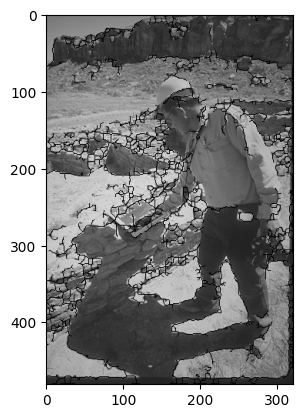

In [35]:
plot_edges_against_base(cv2.ximgproc.thinning(filtered_mask), arr)
